In [2]:
import numpy             as np
import pandas            as pd

In [3]:
from sklearn.preprocessing   import StandardScaler
from sklearn.compose         import ColumnTransformer
from sklearn.linear_model    import ElasticNet
from sklearn.pipeline        import Pipeline
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.metrics         import confusion_matrix, classification_report, accuracy_score
from joblib                  import dump, load

In [4]:
from sklearn.base            import BaseEstimator, TransformerMixin

In [23]:
import warnings
warnings.filterwarnings('ignore')

### Трансформер с моделью для предсказания возраста пассажира

In [37]:
class AgePredictor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = load("ages_full_train_data").best_estimator_
        self.features = None
        self.is_fitted = False
        
    def fit(self, X, y=None):
        df_for_train = X[X['Age'].notna()]
        
        if len(df_for_train) > 0:
            self.model.fit(df_for_train.drop(columns='Age'), df_for_train['Age'])
            self.is_fitted = True
        
        return self

    def transform(self, X):
        print('age transforms')
        
        X_copy = X.copy()
        
        if not self.is_fitted:
            return X_copy

        df_for_train = X_copy[X_copy['Age'].notna()]
        df_for_pred = X_copy[X_copy['Age'].isna()]
        
        if len(df_for_pred) > 0:
            predicted_ages = self.model.predict(df_for_pred.drop(columns='Age'))
            X_copy.loc[df_for_pred.index, 'Age'] = predicted_ages
        
        return X_copy

#### Использованная модель и сетка, по которой был совершен поиск

In [38]:
model = load("ages_full_train_data")

In [43]:
model.param_grid

{'model__l1_ratio': array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333, 1.        ]),
 'model__alpha': [0.01, 0.3, 0.5, 0.6, 1.0, 2.0]}

In [39]:
model.best_estimator_

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Трансформер для признаков 

In [40]:
class TitanicTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.df = None
        self.all_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'class_1', 'class_2',
       'class_3', 'C', 'Q', 'S', 'male', 'parch_0', 'parch_1', 'parch_2',
       'parch_3', 'parch_4', 'parch_5', 'parch_6', 'SibSp_0', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T']
        pass

    def fit(self, X, y=None):
        self.df = X.copy()
        return self


    def transform(self, X):
        print('titanic transforms')
        df = X
        df['Cabin'] = df['Cabin'].str[0]
        
        df = pd.concat(
            objs = [
        df.drop(columns=['PassengerId','Pclass', 'Name', 'Embarked', 'Sex', 'Ticket', 'Cabin', 'Age']), 
                pd.get_dummies(df['Pclass'],   dtype=int, prefix = 'class'),
                pd.get_dummies(df['Embarked'], dtype=int),
                pd.get_dummies(df['Sex'],      dtype=int, drop_first=True),
                pd.get_dummies(df['Parch'],    dtype=int, prefix = 'parch'),
                pd.get_dummies(df['SibSp'],    dtype=int, prefix = 'SibSp'),
                pd.get_dummies(df['Cabin'],    dtype=int, prefix = 'Cabin', dummy_na=True)
                
            ], axis = 1)
        for col in self.all_cols:
            if col not in df.columns:
                df[col] = 0
        for col in df:
            if col not in self.all_cols:
                df = df.drop(columns = col)
        return df[self.all_cols]

### Итоговый пайплайн

In [45]:
model_survival_final = load("GB_for_surviving_2")

final_pipe = Pipeline(
    steps = [
        ("preprocessor",  TitanicTransformer()),
        ("age_predictor", AgePredictor()),
        ("model",         model_survival_final.best_estimator_)
    ]
)

#### Использованная модель и сетка, по которой был совершен поиск

In [46]:
model_survival_final.param_grid

{'model__loss': ['log_loss', 'exponential'],
 'model__learning_rate': [0.01, 0.1],
 'model__criterion': ['friedman_mse'],
 'model__max_depth': [8, 9, 10],
 'model__n_estimators': array([100, 150, 200]),
 'model__max_features': ['sqrt', 'log2'],
 'model__min_samples_split': [11, 12, 13],
 'model__min_samples_leaf': [3, 4]}

In [47]:
model_survival_final.best_estimator_

,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,loss,'log_loss'
,learning_rate,0.01
,n_estimators,np.int64(100)
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,11
,min_samples_leaf,4


In [27]:
df = pd.read_csv("train.csv")
X = df.drop(columns='Survived')
y = df['Survived']

final_pipe.fit(X, y)

titanic transforms
age transforms


,steps,"[('preprocessor', ...), ('age_predictor', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,loss,'log_loss'
,learning_rate,0.01
,n_estimators,np.int64(100)


In [28]:
df2 = pd.read_csv('test.csv')
X = df2.copy()
X.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [29]:
X.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [30]:
X['Fare'] = X['Fare'].fillna(X['Fare'].mean())
X.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [31]:
df_res = df2[['PassengerId']].copy()
df_res['Survived'] = final_pipe.predict(X)

titanic transforms
age transforms


In [32]:
df_res

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [33]:
df_res.to_csv('res1.csv', index=False)

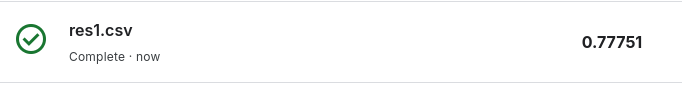